In [1]:
import os, time, itertools
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from scipy.linalg import expm, eig, logm
from scipy import sparse
from scipy.sparse.linalg import inv
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, IBMQ
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.compiler import transpile, assemble
from qiskit.quantum_info import DensityMatrix
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
from operators.triangle_plaquette_hamiltonian import TrianglePlaquetteHamiltonian
from operators.pauli_hamiltonian import PauliHamiltonian
from quantum_circuit.trotterization import trotter_electric, trotter_coupling, trotter_plaquette
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)
from qiskit.providers.jobstatus import JobStatus
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from utils.matrix_operations import *
from utils.circuits import *
from quantum_info.expectation import expectation
from quantum_info.mitigation_gate import noise_mitigation_gate

In [2]:
sig = []
sig.append(sparse.eye(2))
sig.append(sparse.csr_matrix(np.array([[0, 1], [1, 0]])))
sig.append(sparse.csr_matrix(np.array([[0, -1j], [1j, 0]])))
sig.append(sparse.csr_matrix(np.array([[1, 0], [0, -1]])))

In [3]:
def dec_to_binary_str(dec, n_dig):
    s = bin(dec).replace("0b", "")
    return '0'*(n_dig - len(s)) +s 

# The toric code with multiple layers on $2\times 2$ square lattice torus
\begin{align}
    \hat{H}'_{TC, \triangle} &= -J_e \sum_a \hat{E}_a - J_m \sum_\triangle \hat{U}_\triangle \\
    &= -J_e \sum_a \prod_s\prod_{j \in +_{a, s}} \sigma^z_j - J_m \sum_\triangle \prod_{j \in \triangle} \sigma^x_j
\end{align}
![torus](2x2torus.png)

In [1]:
HTC = PauliHamiltonian([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], 
    [{0:"Z", 1:"Z", 4:"Z", 5:"Z", 0+8:"Z", 1+8:"Z", 4+8:"Z", 5+8:"Z"}, 
     {0:"Z", 3:"Z", 4:"Z", 7:"Z", 0+8:"Z", 3+8:"Z", 4+8:"Z", 7+8:"Z"},  
     {1:"Z", 2:"Z", 5:"Z", 6:"Z", 1+8:"Z", 2+8:"Z", 5+8:"Z", 6+8:"Z"}, 
     {2:"Z", 3:"Z", 6:"Z", 7:"Z", 2+8:"Z", 3+8:"Z", 6+8:"Z", 7+8:"Z"}, 
     {0:"X", 1:"X", 2:"X", 3:"X"}, 
     {1:"X", 3:"X", 4:"X", 6:"X"},  
     {0:"X", 2:"X", 5:"X", 7:"X"}, 
     {4:"X", 5:"X", 6:"X", 7:"X"}, 
     {0+8:"X", 1+8:"X", 2+8:"X", 3+8:"X"}, 
     {1+8:"X", 3+8:"X", 4+8:"X", 6+8:"X"},  
     {0+8:"X", 2+8:"X", 5+8:"X", 7+8:"X"}, 
     {4+8:"X", 5+8:"X", 6+8:"X", 7+8:"X"}
    ], 16)

NameError: name 'PauliHamiltonian' is not defined

In [ ]:
HTC.eigensystem(k=32)

# U(1) model on a 2x2 torus with triangular one layer 2D spatial lattice
![torus_triangle](2x2torus_tri.png)

In [5]:
HQED = PauliHamiltonian([-1]*20, 
    [{0+3*i: "+", 1+3*i: "+", 2+3*i: "+"} for i in range(4)]
    +[{0+3*i: "-", 1+3*i: "-", 2+3*i: "-"} for i in range(4)]
    +[{(8+3*i)%12: "+", 10-3*i: "+", 0+3*i: "+"} for i in range(4)]
    +[{(8+3*i)%12: "-", 10-3*i: "-", 0+3*i: "-"} for i in range(4)]
    #[{0+3*i: "Z", 1+3*i: "Z", 2+3*i: "Z"} for i in range(4)]
    #+[{(8+3*i)%12: "Z", 10-3*i: "Z", 0+3*i: "Z"} for i in range(4)]
    +[{i[j]: "Z" for j in range(6)} for i in [[0, 1, 3, 5, 7, 8], [0, 2, 3, 4, 10, 11], [1, 2, 6, 7, 9, 11], [4, 5, 6, 8, 9, 10]]] # gauge term
    , 12)

In [6]:
eigval, eigvec = HQED.eigensystem()

Computing the matrix...
Computing the eigensystem...


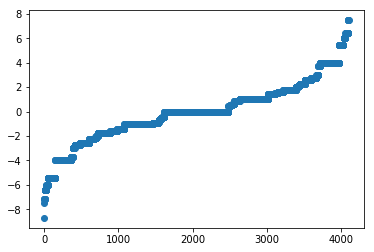

In [7]:
plt.scatter(range(eigval.shape[0]), eigval)
plt.show()

In [8]:
eigval

array([-8.69041576e+00, -7.46410162e+00, -7.16227766e+00, -7.16227766e+00,
       -7.16227766e+00, -7.16227766e+00, -7.16227766e+00, -7.16227766e+00,
       -7.16227766e+00, -6.44948974e+00, -6.44948974e+00, -6.44948974e+00,
       -6.44948974e+00, -6.44948974e+00, -6.44948974e+00, -6.44948974e+00,
       -6.44948974e+00, -6.44948974e+00, -6.44948974e+00, -6.44948974e+00,
       -6.44948974e+00, -6.44948974e+00, -6.44948974e+00, -6.44948974e+00,
       -6.44948974e+00, -6.44948974e+00, -6.44948974e+00, -6.44948974e+00,
       -6.44948974e+00, -6.44948974e+00, -6.00000000e+00, -6.00000000e+00,
       -6.00000000e+00, -6.00000000e+00, -6.00000000e+00, -6.00000000e+00,
       -6.00000000e+00, -6.00000000e+00, -6.00000000e+00, -6.00000000e+00,
       -6.00000000e+00, -6.00000000e+00, -6.00000000e+00, -6.00000000e+00,
       -6.00000000e+00, -6.00000000e+00, -6.00000000e+00, -6.00000000e+00,
       -6.00000000e+00, -6.00000000e+00, -6.00000000e+00, -5.41421356e+00,
       -5.41421356e+00, -

In [9]:
[dec_to_binary_str(idx, 12) for idx in np.where(eigvec[:, 0] > 0.1)[0]]

['000000000000']

# U(1) model on an octahedron with triangular one layer 2D spatial lattice
![octahedron](octahedron.png)

In [9]:
HQED_oct = PauliHamiltonian([-1]*22, 
    [{0+3*i: "+", 1+3*i: "+", 2+3*i: "+"} for i in range(4)]
    +[{0+3*i: "-", 1+3*i: "-", 2+3*i: "-"} for i in range(4)]
    +[{i: "+", j: "+", k: "+"} for i, j, k in [[0, 3, 10], [2, 4, 6], [1, 7, 9], [5, 8, 11]]]
    +[{i: "-", j: "-", k: "-"} for i, j, k in [[0, 3, 10], [2, 4, 6], [1, 7, 9], [5, 8, 11]]]
    #[{0+3*i: "Z", 1+3*i: "Z", 2+3*i: "Z"} for i in range(4)]
    #+[{i: "Z", j: "Z", k: "Z"} for i, j, k in [[0, 3, 10], [2, 4, 6], [1, 7, 9], [5, 8, 11]]]
    +[{i[j]: "Z" for j in range(4)} for i in [[0, 1, 9, 10], [0, 2, 3, 4], [1, 2, 6, 7], [4, 5, 6, 8], [3, 5, 10, 11], [7, 8, 9, 11]]] # gauge term
    , 12)

In [10]:
eigval_oct, eigvec_oct = HQED_oct.eigensystem()

Computing the matrix...
Computing the eigensystem...


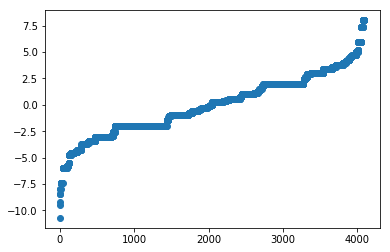

In [11]:
plt.scatter(range(eigval_oct.shape[0]), eigval_oct)
plt.show()

In [12]:
eigval_oct

array([-1.06904158e+01, -9.46410162e+00, -9.16227766e+00, -8.44948974e+00,
       -8.44948974e+00, -8.44948974e+00, -8.00000000e+00, -8.00000000e+00,
       -8.00000000e+00, -7.41421356e+00, -7.41421356e+00, -7.41421356e+00,
       -7.41421356e+00, -7.41421356e+00, -7.41421356e+00, -7.41421356e+00,
       -7.41421356e+00, -7.41421356e+00, -7.41421356e+00, -7.41421356e+00,
       -7.41421356e+00, -7.41421356e+00, -7.41421356e+00, -7.41421356e+00,
       -7.41421356e+00, -7.41421356e+00, -7.41421356e+00, -7.41421356e+00,
       -7.41421356e+00, -7.41421356e+00, -7.41421356e+00, -7.41421356e+00,
       -7.41421356e+00, -7.41421356e+00, -7.41421356e+00, -7.41421356e+00,
       -6.00000000e+00, -6.00000000e+00, -6.00000000e+00, -6.00000000e+00,
       -6.00000000e+00, -6.00000000e+00, -6.00000000e+00, -6.00000000e+00,
       -6.00000000e+00, -6.00000000e+00, -6.00000000e+00, -6.00000000e+00,
       -6.00000000e+00, -6.00000000e+00, -6.00000000e+00, -6.00000000e+00,
       -6.00000000e+00, -

In [31]:
HTC = PauliHamiltonian([-1]*12, 
    [{0+3*i: "X", 1+3*i: "X", 2+3*i: "X"} for i in range(4)]
    +[{(8+3*i)%12: "X", 10-3*i: "X", 0+3*i: "X"} for i in range(4)]
    +[{i[j]: "Z" for j in range(6)} for i in [[0, 1, 3, 5, 7, 8], [0, 2, 3, 4, 10, 11], [1, 2, 6, 7, 9, 11], [4, 5, 6, 8, 9, 10]]] # gauge term
    , 12)

In [32]:
eigval, eigvec = HTC.eigensystem()

Computing the matrix...
Computing the eigensystem...


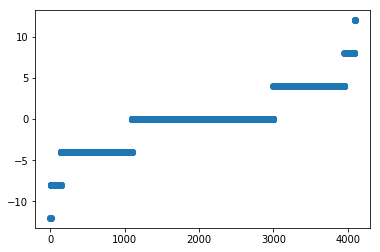

In [33]:
plt.scatter(range(eigval.shape[0]), eigval)
plt.show()

In [34]:
eigval

array([-1.20000000e+01, -1.20000000e+01, -1.20000000e+01, -1.20000000e+01,
       -8.00000000e+00, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
       -8.00000000e+00, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
       -8.00000000e+00, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
       -8.00000000e+00, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
       -8.00000000e+00, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
       -8.00000000e+00, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
       -8.00000000e+00, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
       -8.00000000e+00, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
       -8.00000000e+00, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
       -8.00000000e+00, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
       -8.00000000e+00, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
       -8.00000000e+00, -8.00000000e+00, -8.00000000e+00, -8.00000000e+00,
       -8.00000000e+00, -

In [27]:
HTC_oct = PauliHamiltonian([-1]*14, 
    [{0+3*i: "X", 1+3*i: "X", 2+3*i: "X"} for i in range(4)]
    +[{i: "X", j: "X", k: "X"} for i, j, k in [[0, 3, 10], [2, 4, 6], [1, 7, 9], [5, 8, 11]]]
    +[{i[j]: "Z" for j in range(4)} for i in [[0, 1, 9, 10], [0, 2, 3, 4], [1, 2, 6, 7], [4, 5, 6, 8], [3, 5, 10, 11], [7, 8, 9, 11]]] # gauge term
    , 12)

In [28]:
eigval_oct, eigvec_oct = HTC_oct.eigensystem()

Computing the matrix...
Computing the eigensystem...


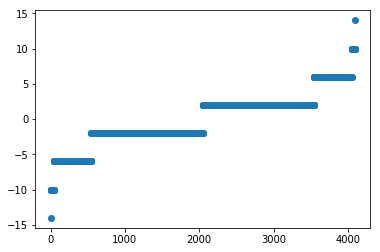

In [29]:
plt.scatter(range(eigval_oct.shape[0]), eigval_oct)
plt.show()

In [30]:
eigval_oct

array([-14., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
       -10., -10., -10., -10., -10., -10., -10., -10., -10., -10., -10.,
        -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,
        -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,
        -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,
        -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,
        -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,
        -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,
        -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,
        -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,
        -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,
        -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -6.,  -